In [1]:
import cv2
import numpy as np
import pytesseract
import re
from PIL import Image
import os
os.environ['TESSDATA_PREFIX'] = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

class ImageAligner:
    @staticmethod
    def align_image_by_contour(image):

        gray = cv2.bitwise_not(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)) 

        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        largest_contour = max(contours, key=cv2.contourArea)
        rect = cv2.minAreaRect(largest_contour)
        box = cv2.boxPoints(rect)
        box = np.intp(box)

        width = int(rect[1][0])
        height = int(rect[1][1])

        if width < height:
            width, height = height, width

        pts_dst = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype="float32")
        h, status = cv2.findHomography(box, pts_dst)
        aligned_image = cv2.warpPerspective(image, h, (width, height))

        return aligned_image
    
    @staticmethod
    def align_image_by_content(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
        scale_percent = 200  
        width = int(gray.shape[1] * scale_percent / 100)
        height = int(gray.shape[0] * scale_percent / 100)
        dim = (width, height)
        gray = cv2.resize(gray, dim, interpolation=cv2.INTER_AREA)
    
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        gray = cv2.medianBlur(gray, 3)

        try:
         osd = pytesseract.image_to_osd(gray)
         angle = float(re.search('(?<=Rotate: )\d+', osd).group(0))

         if angle != 0:
            angle = -angle

            (h, w) = image.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

            return rotated
         
        except pytesseract.TesseractError as e:
            print(f"Tesseract error: {e}")
            return image
        
    @staticmethod
    def align_image_by_hough_transform(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 150, apertureSize=3)
        lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

        if lines is not None:
            angles = []
            for rho, theta in lines[:, 0]:
                angle = np.degrees(theta) - 90
                angles.append(angle)

                median_angle = np.median(angles)
                angle = -median_angle

                (h, w) = image.shape[:2]
                center = (w // 2, h // 2)
                M = cv2.getRotationMatrix2D(center, angle, 1.0)
                rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

                return rotated
        else:
            raise ValueError("Не удалось найти линии для выравнивания изображения.")

    @staticmethod    
    def many_times(output_path, times):

            im = Image.open(output_path)
            width, height = im.size
            new_width = width * times
            new_height = height * times
            resized_image = im.resize((new_width, new_height))
            opencv_image = cv2.cvtColor(np.array(resized_image), cv2.COLOR_RGB2BGR)
            return opencv_image


<>:50: SyntaxWarning: invalid escape sequence '\d'
<>:50: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Мвидео\AppData\Local\Temp\ipykernel_10220\3241834862.py:50: SyntaxWarning: invalid escape sequence '\d'
  angle = float(re.search('(?<=Rotate: )\d+', osd).group(0))


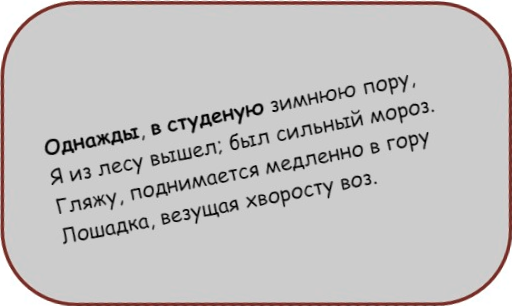

In [7]:
image = cv2.imread('Project1.jpg')
aligned_image = ImageAligner.align_image_by_contour(image)
pil_image = Image.fromarray(aligned_image)
pil_image

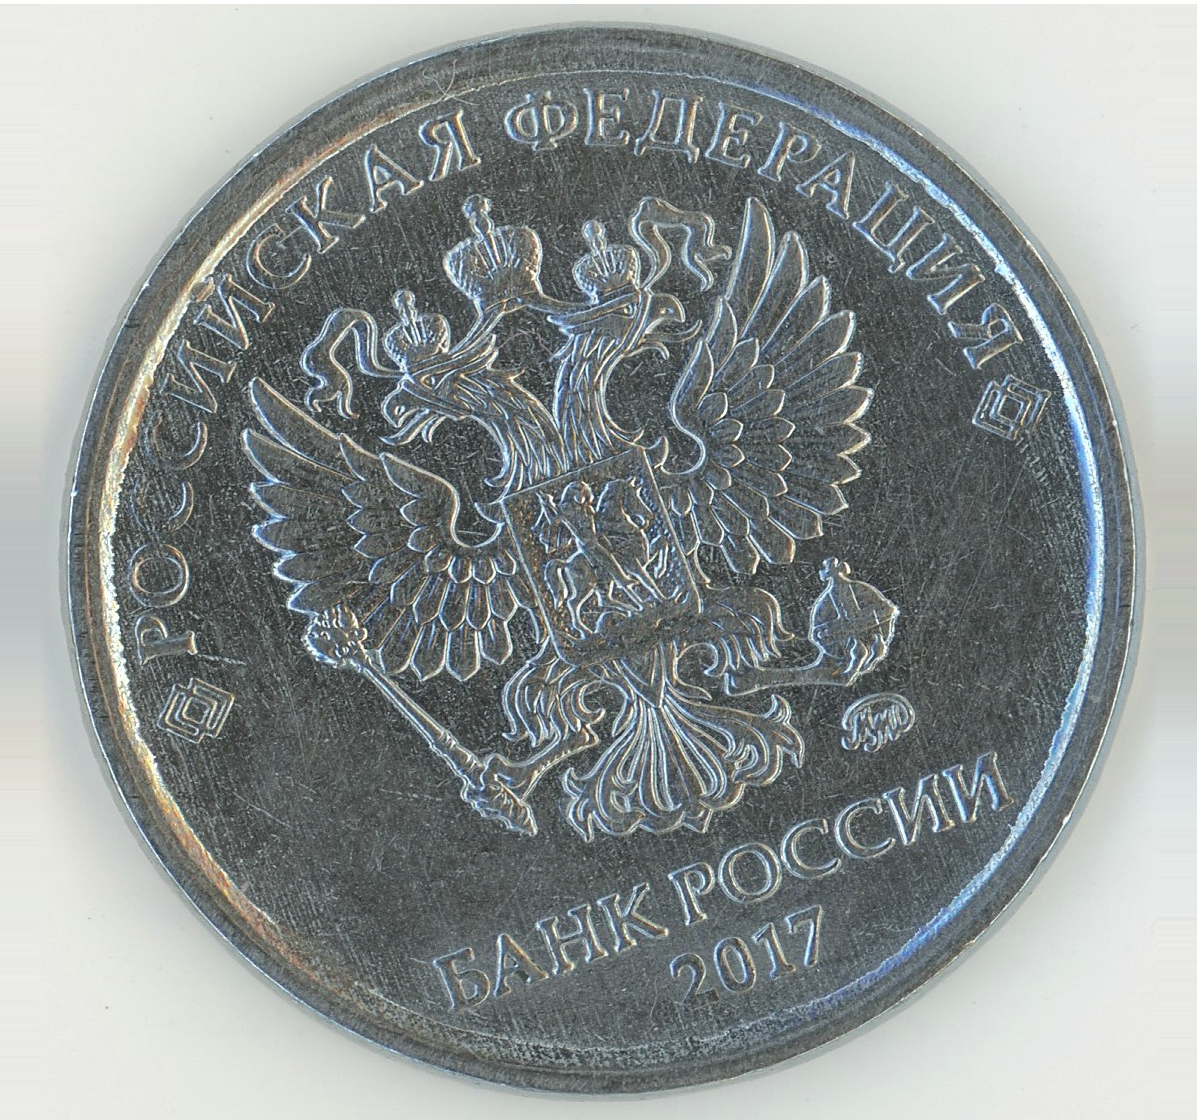

In [8]:
image = cv2.imread('Project2.jpg')
aligned_image = ImageAligner.align_image_by_hough_transform(image)
pil_image = Image.fromarray(aligned_image)
pil_image